# Determining which FERC expenses are fixed vs. variable

In the steam table - the table with info on generation and expenses from large plants - there are a list of non-production expenses. We wanted to determine which of those expenses were fixed (not tied to generation) and which were varible (tied to generation). Form 1 documentaion does not include this distinction, so instead of guessing based on the feild, we wanted to see which expense was actually correlated to production. The formaual  variable_fixed_production_expenses is being used in other analysis. We plotted generation to each expense to generation, and plotted each plants correlation coefficient by expense.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pudl_engine  = pudl.connect_db()

In [3]:
def variable_fixed_production_expenses(capacity_factor, pudl_engine):
    plants_steam_ferc1_tbl = pd.read_sql_query('SELECT * FROM plants_steam_ferc1', pudl_engine)
    plants_steam_ferc1_tbl['capacity_factor'] = \
        (plants_steam_ferc1_tbl['net_generation_mwh'] / (365*24*plants_steam_ferc1_tbl['total_capacity_mw']))
    
    # Limit plants by capacity factor
    plants_steam_ferc1_tbl = plants_steam_ferc1_tbl[plants_steam_ferc1_tbl['capacity_factor'] > capacity_factor]
    expenses = plants_steam_ferc1_tbl.filter(regex='expns').columns.tolist()
    production_expns = {}
    for expns in expenses:
        mwh_plants = plants_steam_ferc1_tbl.net_generation_mwh[plants_steam_ferc1_tbl[expns] != 0 ]
        expns_plants = plants_steam_ferc1_tbl[expns][plants_steam_ferc1_tbl[expns] != 0 ]
        production_expns[expns] = np.corrcoef(mwh_plants,expns_plants)[0,1]
    
    return(production_expns)

In [4]:
variable_fixed_production_expenses(.5, pudl_engine)

{'expns_allowances': 0.24801451134001593,
 'expns_boiler': 0.78445725955494494,
 'expns_coolants': 0.41446698707556628,
 'expns_electric': 0.42287357484039662,
 'expns_engineering': 0.47338962105264409,
 'expns_fuel': 0.73607356829722714,
 'expns_misc_power': 0.4629796175721525,
 'expns_misc_steam': 0.44916424682230893,
 'expns_operations': 0.44184363596808085,
 'expns_per_mwh': -0.086965013588199996,
 'expns_plants': 0.60224384970543599,
 'expns_production_total': 0.87542349003071929,
 'expns_rents': 0.30687912056852212,
 'expns_steam': 0.64577960657061251,
 'expns_steam_other': -0.12073435038524498,
 'expns_structures': 0.56689697303880626,
 'expns_transfer': 0.4817054733945545}

### Plotting expenses to generation

In [5]:
plants_steam_ferc1_tbl = pd.read_sql_query('SELECT * FROM plants_steam_ferc1', pudl_engine)
plants_steam_ferc1_tbl['capacity_factor'] = \
    (plants_steam_ferc1_tbl['net_generation_mwh'] / (365*24*plants_steam_ferc1_tbl['total_capacity_mw']))

expns_operations 0.441843635968
expns_fuel 0.736073568297
expns_coolants 0.414466987076
expns_steam 0.645779606571
expns_steam_other -0.120734350385
expns_transfer 0.481705473395
expns_electric 0.42287357484
expns_misc_power 0.462979617572
expns_rents 0.306879120569
expns_allowances 0.24801451134
expns_engineering 0.473389621053
expns_structures 0.566896973039
expns_boiler 0.784457259555
expns_plants 0.602243849705
expns_misc_steam 0.449164246822
expns_production_total 0.875423490031
expns_per_mwh -0.0869650135882


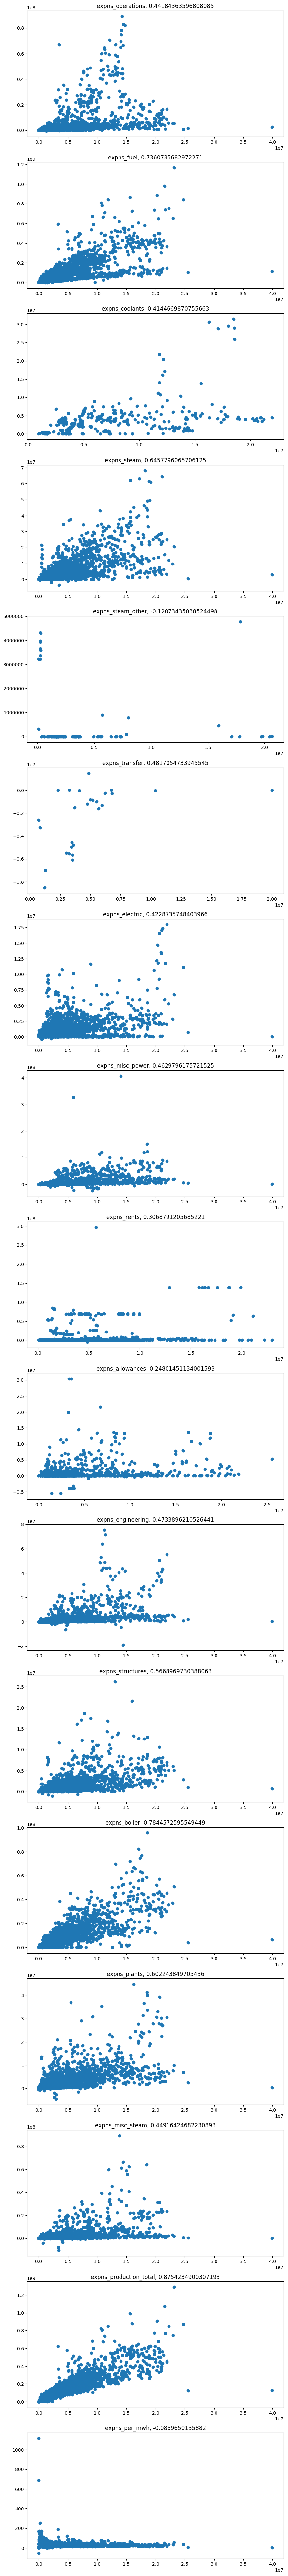

In [6]:
# Limit plants by capacity factor
plants_steam_ferc1_tbl = plants_steam_ferc1_tbl[plants_steam_ferc1_tbl['capacity_factor'] > .5]

f, axarr = plt.subplots(17, dpi=100)
f.set_figwidth(10)
f.set_figheight(17*6)
expenses = plants_steam_ferc1_tbl.filter(regex='expns').columns.tolist()
for expns, ax in zip(expenses, axarr):
    mwh_plants = plants_steam_ferc1_tbl.net_generation_mwh[plants_steam_ferc1_tbl[expns] != 0 ]
    expns_plants = plants_steam_ferc1_tbl['{}'.format(expns)][plants_steam_ferc1_tbl[expns] != 0 ]

    print(expns, np.corrcoef(mwh_plants,expns_plants)[0,1])
    x = ax.scatter(mwh_plants, expns_plants)
    ax.set_title('{}, {}'.format(expns, np.corrcoef(mwh_plants,expns_plants)[0,1]))

### Testing the correlation of individual expenses

In [8]:
plants = plants_steam_ferc1_tbl[['plant_name', 'respondent_id']].drop_duplicates()

In [9]:
[x for x in plants.itertuples(index=False)]
for x in plants.itertuples(index=False):
    print("{}, {}".format(x.respondent_id,x.plant_name))

186, Altavista
186, Bremo Bluff
186, Chesapeake
186, Chesterfield
186, Clover
186, Mecklenburg
186, Mount Storm
186, North Anna
186, North Branch
186, Southampton
186, Surry
186, Pittsylvania
141, Boardman
141, Coyote Springs
141, Colstrip
82, Tyrone
82, Green River
82, Ew Brown
82, Ghent
210, Walter Scott, Jr. Ec
210, Neal
210, Riverside
210, Ottumwa
210, Louisa
210, Quad-Cities
79, Montrose
79, Hawthorn 5
79, Lacygne
79, Lacygne 50%
79, Iatan
79, Iatan 70%
79, Wolf Creek
122, Big Stone
122, Coyote
122, Neal #4
122, Colstrip 4
134, Carbon
134, Cholla
134, Colstrip
134, Craig
134, Dave Johnston
134, Hayden
134, Hunter Unit No. 1
134, Hunter Unit No. 2
134, Hunter Unit No. 3
134, Hunter - Total Plant
134, Huntington
134, Jim Bridger
134, Naughton
134, Wyodak
134, Little Mountain
134, Hermiston
134, Currant Creek
88, Mill Creek
88, Cane Run
88, Trimble County
95, R.M. Heskett
95, Lewis & Clark
95, Big Stone
95, Coyote
42, J. M. Stuart
42, Killen
42, East Bend
42, Miami Fort
42, W. H. Zim

In [10]:
s1 = pd.DataFrame(columns=['respondent_id','plant_name','correlation','net_gen'])
for x in plants.itertuples(index=False):
    plant_info = plants_steam_ferc1_tbl[(plants_steam_ferc1_tbl['respondent_id']== x.respondent_id)
                        & (plants_steam_ferc1_tbl['plant_name']== x.plant_name)]
    mwh = plant_info.net_generation_mwh
    expns = plant_info.expns_fuel
    r = np.corrcoef(expns,mwh)[0,1]
    if not np.isnan(r):
        s1 = s1.append({'respondent_id':x.respondent_id, 'plant_name':x.plant_name, 'correlation':r},ignore_index=True)
    print("{}, {} = {:.2}".format(x.respondent_id,x.plant_name, r))

186, Altavista = -1.0
186, Bremo Bluff = 1.0
186, Chesapeake = 0.95
186, Chesterfield = 0.18
186, Clover = 0.13
186, Mecklenburg = nan
186, Mount Storm = 0.16
186, North Anna = 0.85
186, North Branch = 1.0
186, Southampton = 0.62
186, Surry = 0.94
186, Pittsylvania = 0.9
141, Boardman = 0.74
141, Coyote Springs = 0.071
141, Colstrip = 0.25
82, Tyrone = 1.0
82, Green River = -0.17
82, Ew Brown = 1.0
82, Ghent = 0.62
210, Walter Scott, Jr. Ec = 0.91
210, Neal = 0.9
210, Riverside = 0.076
210, Ottumwa = 0.097


/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2496: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2496: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


210, Louisa = 0.58
210, Quad-Cities = 0.95
79, Montrose = 0.17
79, Hawthorn 5 = -0.0089
79, Lacygne = nan
79, Lacygne 50% = -1.0
79, Iatan = nan
79, Iatan 70% = -0.76
79, Wolf Creek = 0.94
122, Big Stone = 0.74
122, Coyote = 0.51
122, Neal #4 = -0.18
122, Colstrip 4 = 0.22
134, Carbon = -0.17
134, Cholla = -0.12
134, Colstrip = 0.4
134, Craig = 0.0039
134, Dave Johnston = -0.11
134, Hayden = 0.23
134, Hunter Unit No. 1 = -0.024
134, Hunter Unit No. 2 = 0.3
134, Hunter Unit No. 3 = 0.22
134, Hunter - Total Plant = -0.005
134, Huntington = -0.55
134, Jim Bridger = -0.72

/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2569: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/christinagosnell/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2570: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]



134, Naughton = 0.4
134, Wyodak = 0.3
134, Little Mountain = 0.091
134, Hermiston = -0.62
134, Currant Creek = 0.6
88, Mill Creek = -0.55
88, Cane Run = -0.75
88, Trimble County = 0.81
95, R.M. Heskett = 0.35
95, Lewis & Clark = 0.19
95, Big Stone = 0.71
95, Coyote = 0.54
42, J. M. Stuart = 0.39
42, Killen = 0.072
42, East Bend = 0.8
42, Miami Fort = 0.78
42, W. H. Zimmer = 0.56
42, W. C. Beckjord = 0.26
42, Conesville = 0.015
160, Williams = -0.26
129, Clover = 0.81
129, North Anna = 0.75
133, Diablo Canyon 1 & 2 = 0.33
133, Humboldt Bay 1 & 2 = -0.49
30, Mansfield = nan
126, Beaver Valley = 0.57
126, Perry = 0.036
175, Beaver Valley = 0.57
175, Mansfield = nan
281, Prairie Creek 4 = -1.0
281, Sutherland = 0.97
281, Ottumwa = -0.071
281, George Neal # 3 = 0.52
281, Burlington = -0.31
281, M. L. Kapp = nan
281, Lansing = 0.53
281, George Neal #4 = 0.091
281, Louisa = 0.43
41, Campbell 1 & 2 = 0.48
41, Cobb 4-5 = nan
41, Whiting = 0.31
41, Karn 1 & 2 = 0.086
41, Weadock 7 & 8 = -0.39
1

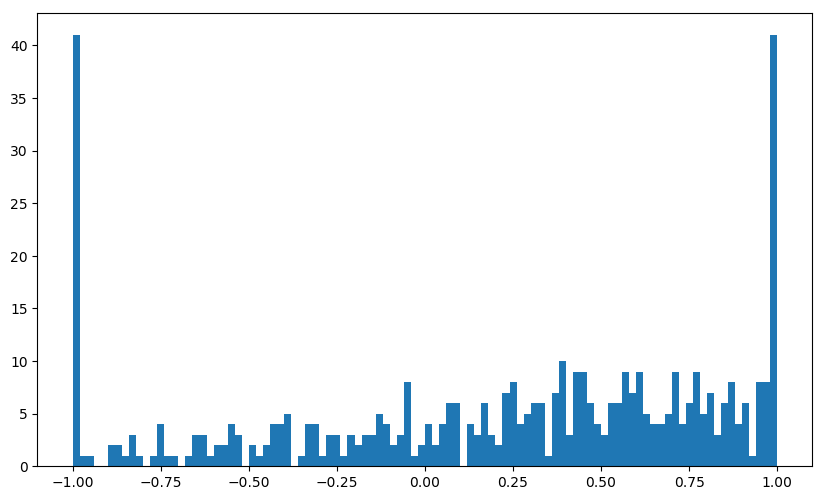

In [11]:
f, (ax) = plt.subplots(1, dpi=100)
f.set_figwidth(10)
f.set_figheight(6)
x = ax.hist(s1['correlation'],bins=100)

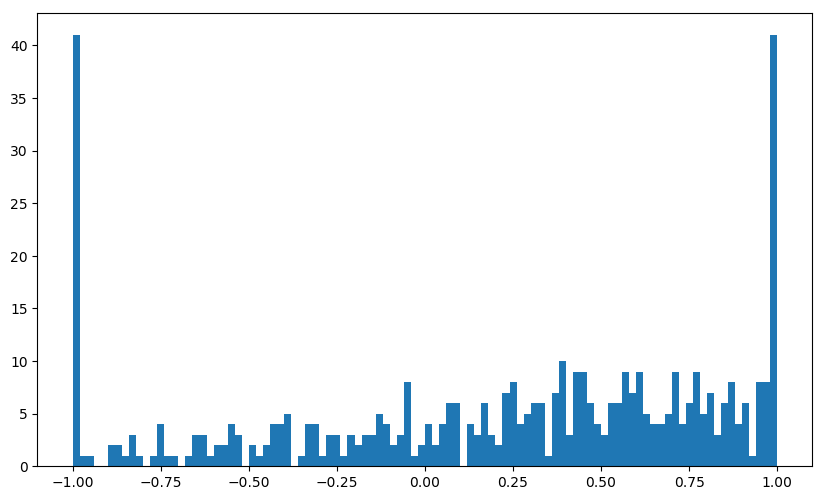

In [12]:
f, (ax) = plt.subplots(1, dpi=100)
f.set_figwidth(10)
f.set_figheight(6)
x = ax.hist(s1['correlation'],bins=100)

### Generate list of correlation coefficients 

In [13]:
expenses = plants_steam_ferc1_tbl.filter(regex='expns').columns.tolist()

In [14]:
for expns in expenses:
    mwh = plants_steam_ferc1_tbl.net_generation_mwh
    x = plants_steam_ferc1_tbl[expns]
    r = np.corrcoef(x,mwh)[0,1]
    print("{} = {:.2}".format(expns, r))

expns_operations = 0.43
expns_fuel = 0.72
expns_coolants = 0.3
expns_steam = 0.6
expns_steam_other = -0.03
expns_transfer = 0.023
expns_electric = 0.39
expns_misc_power = 0.46
expns_rents = 0.18
expns_allowances = 0.16
expns_engineering = 0.45
expns_structures = 0.56
expns_boiler = 0.72
expns_plants = 0.59
expns_misc_steam = 0.44
expns_production_total = 0.85
expns_per_mwh = -0.09
